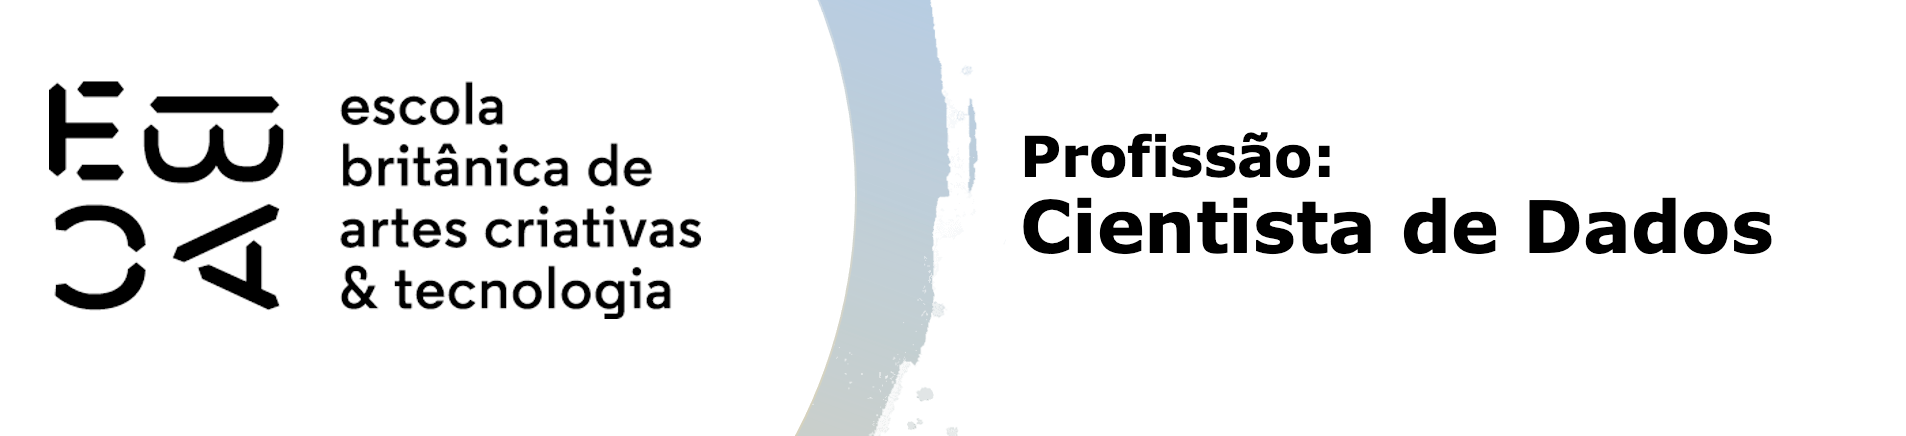

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from statsmodels.stats.outliers_influence import outlier_test
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import shapiro

In [96]:
df = pd.read_csv('C:/Users/Arthur/Desktop/EBAC/Curso 3 - Cientista de Dados/Módulo 34 - Regressão III/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [97]:
#O professor pediu no vídeo para encontrar o log da renda
#e para separar os últimos 3 meses para teste

df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [98]:
media_tempo_emprego = df['tempo_emprego'].mean()
df['tempo_emprego'] = df['tempo_emprego'].fillna(media_tempo_emprego)

In [99]:
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [100]:
df.tail(2)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2016-03-01,3024,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49
2016-03-01,6074,F,N,S,0,Pensionista,Superior completo,Separado,Casa,62,7.746165,1.0,2243.21


In [101]:
df.reset_index(inplace=True)

In [102]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

In [103]:
data_ultimos_3_meses = df['data_ref'].iloc[-1] - pd.DateOffset(months=3)

In [104]:
dados_teste = df[df['data_ref'] >= data_ultimos_3_meses]
dados_treinamento = df[df['data_ref'] < data_ultimos_3_meses]

In [105]:
dados_teste.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
550000,2015-12-01,14180,F,S,N,0,Assalariado,Superior completo,Casado,Casa,56,20.887671,2.0,28655.39
550001,2015-12-01,14159,F,S,N,0,Assalariado,Superior completo,Casado,Casa,28,9.460274,2.0,3241.54


In [106]:
dados_treinamento.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81


In [107]:
dados_treinamento['log_renda'] = np.log(dados_treinamento['renda'])
dados_teste['log_renda'] = np.log(dados_teste['renda'])

C:\Users\Arthur\AppData\Local\Temp\ipykernel_2348\2560936782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_treinamento['log_renda'] = np.log(dados_treinamento['renda'])
C:\Users\Arthur\AppData\Local\Temp\ipykernel_2348\2560936782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_teste['log_renda'] = np.log(dados_teste['renda'])


In [108]:
dados_treinamento.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508


In [109]:
print(dados_treinamento.dtypes)

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
log_renda                       float64
dtype: object


In [110]:
encoder = OneHotEncoder(sparse=False)

In [111]:
colunas_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 
                       'tipo_residencia']


In [112]:
encoded_cols = pd.DataFrame(encoder.fit_transform(dados_treinamento[colunas_categoricas]))

In [113]:
encoded_cols_names = encoder.get_feature_names(colunas_categoricas)

C:\Users\Arthur\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [114]:
encoded_cols.columns = encoded_cols_names

In [115]:
dados_treinamento = pd.concat([dados_treinamento, encoded_cols], axis=1)

In [116]:
dados_treinamento.drop(colunas_categoricas, axis=1, inplace=True)

In [117]:
X = dados_treinamento[['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'sexo_F', 'sexo_M', 
                       'posse_de_veiculo_N', 'posse_de_veiculo_S', 'posse_de_imovel_N', 'posse_de_imovel_S', 
                       'tipo_renda_Assalariado', 'tipo_renda_Bolsista', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 
                       'tipo_renda_Servidor público', 'educacao_Fundamental', 'educacao_Médio', 'educacao_Pós graduação', 
                       'educacao_Superior completo', 'educacao_Superior incompleto', 'estado_civil_Casado', 
                       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 'estado_civil_Viúvo', 
                       'tipo_residencia_Aluguel', 'tipo_residencia_Casa', 'tipo_residencia_Com os pais', 
                       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']]
y = dados_treinamento['log_renda']

In [118]:
modelo = sm.OLS(y, X)
resultado = modelo.fit()

In [119]:
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                 1.828e+04
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:12:41   Log-Likelihood:            -7.2534e+05
No. Observations:              550000   AIC:                         1.451e+06
Df Residuals:                  549975   BIC:                         1.451e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
qtd_filhos                       -0.1403      0.023     -6.049      0.000      -0.186      -0.095
idade                             0.0045      0.000     27.859      0.000       0.004       0.005
tempo_emprego                     0.1289      0.000    599.505      0.000       0.128       0.129
qt_pessoas_residencia             0.1464      0.023      6.326      0.000       0.101       0.192
sexo_F                            1.6753      0.008    206.515      0.000       1.659       1.691
sexo_M                            1.8140      0.008    224.267      0.000       1.798       1.830
posse_de_veiculo_N                1.7437      0.008    215.879      0.000       1.728       1.760
posse_de_veiculo_S                1.7456      0.008    215.531      0.000       1.730       1.761
posse_de_imovel_N                 1.6525      0.008    204.682      0.000       1.637       1.668
posse_de_imovel_S                 1.8368      0.008    226.973      0.000       1.821       1.853
tipo_renda_Assalariado            0.7475      0.011     70.377      0.000       0.727       0.768
tipo_renda_Bolsista               0.5294      0.045     11.736      0.000       0.441       0.618
tipo_renda_Empresário             0.8883      0.011     82.902      0.000       0.867       0.909
tipo_renda_Pensionista            0.4487      0.011     40.518      0.000       0.427       0.470
tipo_renda_Servidor público       0.8753      0.011     79.212      0.000       0.854       0.897
educacao_Fundamental              0.6145      0.012     50.711      0.000       0.591       0.638
educacao_Médio                    0.6418      0.008     79.618      0.000       0.626       0.658
educacao_Pós graduação            0.7896      0.031     25.329      0.000       0.729       0.851
educacao_Superior completo        0.7737      0.008     95.319      0.000       0.758       0.790
educacao_Superior incompleto      0.6697      0.009     71.839      0.000       0.651       0.688
estado_civil_Casado               0.6009      0.017     35.537      0.000       0.568       0.634
estado_civil_Separado             0.7679      0.008     96.267      0.000       0.752       0.784
estado_civil_Solteiro             0.7508      0.007    104.319      0.000       0.737       0.765
estado_civil_União                0.6108      0.017     35.514      0.000       0.577       0.645
estado_civil_Viúvo                0.7590      0.008     89.774      0.000       0.742       0.776
tipo_residencia_Aluguel           0.6693      0.010     67.184      0.000       0.650       0.689
tipo_residencia_Casa              0.5782      0.005    112.496      0.000       0.568       0.588
tipo_residencia_Com os pais       0.6103      0.007     88.309      0.000       0.597       0.624
tipo_residencia_Comunitário       0.5198     

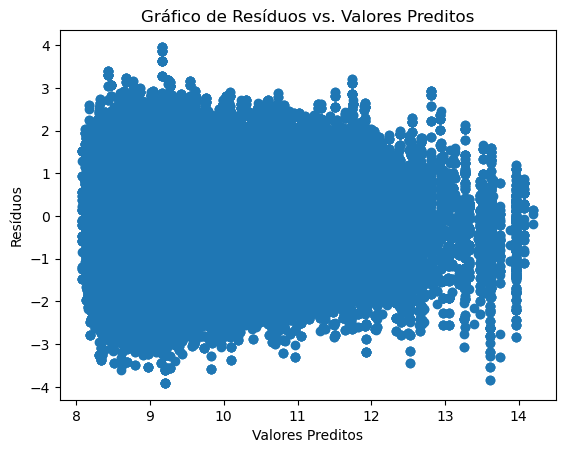

In [120]:
residuos = resultado.resid

plt.scatter(resultado.predict(), residuos)
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos vs. Valores Preditos")
plt.show()

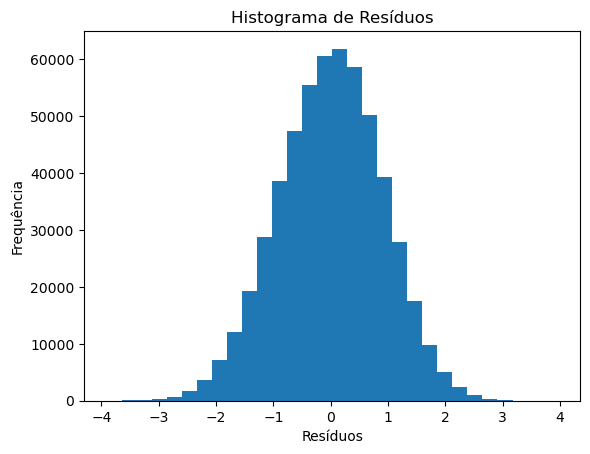

In [121]:
plt.hist(residuos, bins=30)
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.title("Histograma de Resíduos")
plt.show()

RESPOSTA:

O histograma apresentou uma distribuição triangular dos dados, com a maioria deles concentrados em torno de zero. Essa forma característica é um indício positivo de que os resíduos seguem uma distribuição normal ou próxima dela.

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [91]:
modelo = sm.OLS(y, X)
resultado = modelo.fit()
residuos_padronizados = resultado.get_influence().resid_studentized_internal

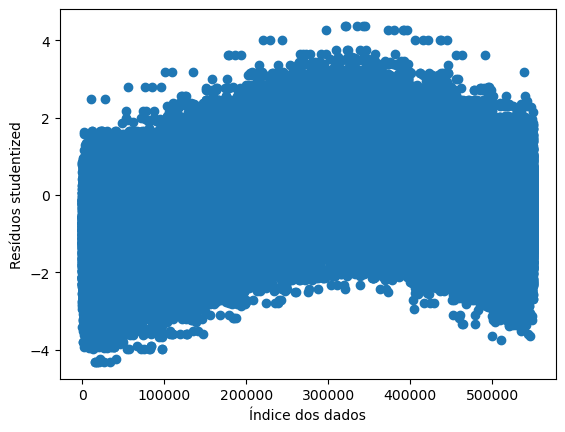

In [92]:
plt.scatter(range(len(residuos_padronizados)), residuos_padronizados)
plt.xlabel('Índice dos dados')
plt.ylabel('Resíduos studentized')
plt.show()

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

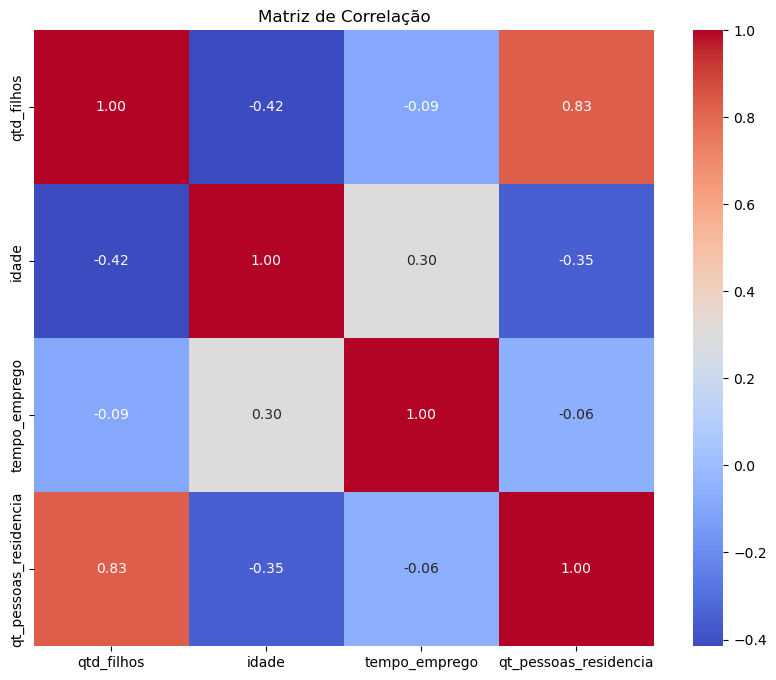

In [93]:
X2 = df[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
        'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']]
matriz_correlacao = X2.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacao, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

In [94]:
vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

C:\Users\Arthur\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                         Variável         VIF
0                      qtd_filhos  196.832216
1                           idade    2.168359
2                   tempo_emprego    1.156803
3           qt_pessoas_residencia  293.119490
4                          sexo_F         inf
5                          sexo_M         inf
6              posse_de_veiculo_N         inf
7              posse_de_veiculo_S         inf
8               posse_de_imovel_N         inf
9               posse_de_imovel_S         inf
10         tipo_renda_Assalariado         inf
11            tipo_renda_Bolsista         inf
12          tipo_renda_Empresário         inf
13         tipo_renda_Pensionista         inf
14    tipo_renda_Servidor público         inf
15           educacao_Fundamental         inf
16                 educacao_Médio         inf
17         educacao_Pós graduação         inf
18     educacao_Superior completo         inf
19   educacao_Superior incompleto         inf
20            estado_civil_Casado 

RESPOSTA:

A análise do VIF revela que a maioria das variáveis apresenta alta multicolinearidade, o que significa que elas não são adequadas para explicar de forma independente a variabilidade do log_renda. No entanto, há duas variáveis que se destacam como melhores candidatas para prever o log_renda: idade e tempo de emprego. Essas duas variáveis possuem baixa correlação com as demais e podem ser consideradas como os principais fatores relacionados ao log_renda.